# Baseline PPO with Curriculum Learning Demo

This notebook demonstrates the improved baseline PPO approach for OpenScope RL with:
- **Curriculum Learning**: Progressive difficulty (3→5→8→12 aircraft)
- **Aggressive Action Masking**: 50-80x reduction in action space
- **Enhanced State Features**: 20 features (was 14) for better decision-making
- **Dense Reward Shaping**: Graduated penalties and progress tracking
- **Fixed Metrics**: Proper violation and exit tracking

**Key Improvements Over Original:**
- Episodes now run 200-300 steps (was 40)
- Action space: 244k → 3-5k effective actions
- Better exploration with smart masking
- Curriculum prevents overwhelming the agent

**Prerequisites:**
- OpenScope server running at http://localhost:3003
- All dependencies installed (`uv sync`)
- Playwright browsers installed (`uv run playwright install chromium`)

## 📚 Learning Objectives

By the end of this notebook, you will understand:

1. **Curriculum Learning** - Progressive difficulty scaling (3→5→8→12 aircraft) for 5-10x faster convergence
2. **Aggressive Action Masking** - Smart masking that reduces exploration space by 50-80x
3. **Dense Reward Shaping** - Graduated penalties and progress tracking for better learning signals
4. **Enhanced State Features** - 20 aircraft features (vs 14) for better situational awareness
5. **PPO Training Loop** - The core mechanics with proper metrics and termination conditions
6. **Multi-Stage Evaluation** - Testing across difficulty levels

**Estimated Time**: 2-3 hours for full curriculum (500k steps) | 15 min for Stage 1 validation (10k steps)
**Prerequisites**: OpenScope server running, dependencies installed  
**Hardware**: CPU works (slow), GPU strongly recommended for full training

## Section 1: Setup & Environment Creation

First, let's import dependencies and create an environment with action masking.

In [1]:
import sys
from pathlib import Path
import os

print(sys.prefix)

# Add parent directory to path
sys.path.append(str(Path.cwd().parent))

# Disable tqdm notebook widgets to avoid JS rendering errors in some Jupyter frontends
os.environ["TQDM_NOTEBOOK"] = "0"

import numpy as np
import matplotlib.pyplot as plt
from contextlib import contextmanager
from stable_baselines3 import PPO
from sb3_contrib.common.wrappers import ActionMasker

from environment import (
    PlaywrightEnv,
    create_action_mask_fn,
    print_action_mask_summary,
    ActionMaskingWrapper,
    DictToMultiDiscreteWrapper,
)
from environment.curriculum import CurriculumManager
from environment.action_masking import get_smart_action_mask
from experiments.metrics import MetricsTracker

# Shared environment configuration (will be overridden by curriculum stages)
ENV_AIRPORT = "KLAS"
ENV_MAX_AIRCRAFT = 50
ENV_HEADLESS = False
ENV_TIMEWARP = 1000
TRAIN_EPISODE_LENGTH = 600
EVAL_EPISODE_LENGTH = 600
ACTION_INTERVAL = 5.0

print("Imports successful!")

/Users/jmzlx/Projects/atc/openscope-rl/.venv
Imports successful!


### Setup Weights & Biases (Optional)

We'll use Weights & Biases to track training metrics. If wandb is not installed or configured, training will continue normally without logging.


In [2]:
# Import wandb utilities
from _wandb_utils import setup_wandb_experiment, WandbATCCallback
import wandb
import os

# Optional: Set WANDB_API_KEY if you have it as an environment variable
# You can get your API key from https://wandb.ai/authorize
# If wandb login worked in terminal, this should not be necessary
# Uncomment and set if needed:
# os.environ["WANDB_API_KEY"] = "your-api-key-here"

# Setup wandb experiment
# Note: If you get permission errors:
# 1. Create the project manually at https://wandb.ai/jmzlx
# 2. Or use offline mode (set offline=True below)
# 3. Sync offline runs later with: wandb sync wandb/offline-run-*
wandb_run = setup_wandb_experiment(
    project_name="openscope-rl",
    run_name="ppo-baseline-demo",
    # entity="jmzlx",  # Uncomment if needed - wandb should auto-detect from login
    # offline=False,  # Set to True to use offline mode (logs saved locally, sync later)
    config={
        "algorithm": "PPO",
        "demo_steps": 10000,
        "airport": ENV_AIRPORT,
        "max_aircraft": ENV_MAX_AIRCRAFT,
        "episode_length": TRAIN_EPISODE_LENGTH,
        "timewarp": ENV_TIMEWARP,
        "learning_rate": 3e-4,
        "batch_size": 64,
        "n_epochs": 10,
        "gamma": 0.99,
        "gae_lambda": 0.95,
        "clip_range": 0.2,
    },
    tags=["demo", "action-masking", "baseline"],
    sync_tensorboard=True,  # Sync tensorboard logs to wandb
)
print(f"✅ WandB run initialized: {wandb_run.url if hasattr(wandb_run, 'url') else 'run started'}")


/Users/jmzlx/Projects/atc/openscope-rl/.venv/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/Users/jmzlx/Projects/atc/openscope-rl/.venv/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This m

✅ WandB initialized in online mode
   Dashboard: https://wandb.ai/openscope-rl/openscope-rl/runs/kf0q23lt
✅ WandB run initialized: https://wandb.ai/openscope-rl/openscope-rl/runs/kf0q23lt


### Create Environment with Action Masking

In [3]:
@contextmanager
def masked_env(
    *,
    airport=ENV_AIRPORT,
    max_aircraft=ENV_MAX_AIRCRAFT,
    headless=ENV_HEADLESS,
    timewarp=ENV_TIMEWARP,
    episode_length=TRAIN_EPISODE_LENGTH,
    action_interval=ACTION_INTERVAL,
):
    """Yield a Playwright environment wrapped for PPO with action masking."""
    env = PlaywrightEnv(
        airport=airport,
        max_aircraft=max_aircraft,
        headless=headless,
        timewarp=timewarp,
        episode_length=episode_length,
        action_interval=action_interval,
    )

    env = DictToMultiDiscreteWrapper(env)
    mask_fn = create_action_mask_fn(env)
    env = ActionMasker(env, mask_fn)

    try:
        yield env
    finally:
        env.close()

### Demo: Action Masking in Action

Let's see how action masking works by examining a few steps.

In [4]:
with masked_env(
    episode_length=EVAL_EPISODE_LENGTH,
) as env:
    print("Environment created!")
    print(f"Observation space: {env.observation_space}")
    print(f"Action space: {env.action_space}")

    obs, info = env.reset()

    # Get aircraft data from the raw state
    aircraft_data = info["raw_state"].get("aircraft", [])

    # Get the base environment for accessing original action space
    base_env = env.unwrapped
    while hasattr(base_env, 'env'):
        base_env = base_env.env
        if not hasattr(base_env, 'env'):
            break

    # Cap the demo to a small number of iterations to avoid long runs
    DEMO_MAX_STEPS = 5

    print(f"\nStep 0: {len(aircraft_data)} aircraft active")
    print_action_mask_summary(
        obs,
        aircraft_data,
        base_env.config.max_aircraft,
        base_env.action_space,  # Original Dict action space
    )

    # Take a few random actions (capped)
    for i in range(DEMO_MAX_STEPS):
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)

        aircraft_data = info["raw_state"].get("aircraft", [])
        print(f"Step {i+1}: {len(aircraft_data)} aircraft, reward={reward:.2f}")

        if terminated or truncated:
            break

    print("\nAction masking demonstration complete!")

Environment created!
Observation space: Dict('aircraft': Box(-inf, inf, (50, 20), float32), 'aircraft_mask': Box(False, True, (50,), bool), 'conflict_matrix': Box(0.0, 1.0, (50, 50), float32), 'global_state': Box(-inf, inf, (4,), float32))
Action space: MultiDiscrete([51  5  9  7  4])

Step 0: 18 aircraft active

ACTION MASK SUMMARY
Active Aircraft: 18 / 50
Valid Aircraft IDs: 0 to 18 (inclusive)
Total Valid Actions: 44 / 76
Action Space Reduction: 42.1%

Step 1: 19 aircraft, reward=-6.35
Step 2: 19 aircraft, reward=-8.44
Step 3: 20 aircraft, reward=-0.10
Step 4: 22 aircraft, reward=1.27
Step 5: 24 aircraft, reward=-10.28

Action masking demonstration complete!


## Section 2: Curriculum Learning Training

Now let's train a PPO agent using curriculum learning - progressively increasing difficulty from 3 to 12 aircraft.

**Two Training Options:**
- **Quick Validation** (15 min): Stage 1 only (3 aircraft, 10k steps) - validates fixes work
- **Full Curriculum** (2-3 hours): All 4 stages (3→5→8→12 aircraft, 500k steps total)

Set `QUICK_MODE = True` below for quick validation, or `False` for full training.

In [5]:
# Configuration: Quick validation or full training?
QUICK_MODE = True  # Set to False for full curriculum (500k steps, 2-3 hours)

# Initialize curriculum manager
curriculum = CurriculumManager()
curriculum.print_curriculum()

# Limit to Stage 1 in quick mode
stages_to_train = [curriculum.stages[0]] if QUICK_MODE else curriculum.stages

print(f"\n{'='*80}")
print(f"TRAINING MODE: {'QUICK VALIDATION' if QUICK_MODE else 'FULL CURRICULUM'}")
print(f"Stages to train: {[s.name for s in stages_to_train]}")
print(f"Total timesteps: {sum(s.timesteps for s in stages_to_train):,}")
print(f"{'='*80}\n")

# Track best model across stages
model = None
best_reward = -float('inf')
stage_results = []

for stage_idx, stage in enumerate(stages_to_train):
    print(f"\n{'#'*80}")
    print(f"# STAGE {stage_idx+1}: {stage.name.upper()} ({stage.max_aircraft} aircraft)")
    print(f"{'#'*80}\n")
    
    # Update reward config threshold for this stage
    from environment.config import RewardConfig
    reward_config = RewardConfig()
    reward_config.min_score_threshold = stage.min_score_threshold
    
    # Create environment for this stage
    with masked_env(
        max_aircraft=stage.max_aircraft,
        episode_length=stage.episode_length,
        timewarp=ENV_TIMEWARP,
    ) as train_env:
        
        # Update environment's reward config
        train_env.unwrapped.config.reward_config.min_score_threshold = stage.min_score_threshold
        
        print(f"✅ Stage {stage.name} environment created")
        print(f"   Aircraft: {stage.max_aircraft}")
        print(f"   Episode length: {stage.episode_length}")
        print(f"   Score threshold: {stage.min_score_threshold}")
        print(f"   Training steps: {stage.timesteps:,}\n")
        
        # Setup wandb for this stage
        wandb_callback = WandbATCCallback(
            project_name="openscope-rl",
            run_name=f"ppo-curriculum-{stage.name}",
            config={
                "algorithm": "PPO",
                "stage": stage.name,
                "max_aircraft": stage.max_aircraft,
                "episode_length": stage.episode_length,
                "min_score_threshold": stage.min_score_threshold,
                "timesteps": stage.timesteps,
                "learning_rate": 3e-4,
                "ent_coef": 0.01,  # Entropy bonus for exploration
            },
            sync_tensorboard=True,
        )
        
        # Create or update model
        if model is None:
            # First stage - create new model
            model = PPO(
                "MultiInputPolicy",
                train_env,
                learning_rate=3e-4,
                n_steps=2048,
                batch_size=64,
                n_epochs=10,
                gamma=0.99,
                gae_lambda=0.95,
                clip_range=0.2,
                ent_coef=0.01,  # Add entropy bonus for better exploration
                verbose=1,
                tensorboard_log="./tensorboard_logs/",
            )
            print("✅ PPO model created")
        else:
            # Subsequent stages - update environment
            model.set_env(train_env)
            print("✅ PPO model updated with new environment")
        
        print(f"   Policy: MultiInputPolicy")
        print(f"   Observation space: {train_env.observation_space}")
        print(f"   Action space: {train_env.action_space}\n")
        
        # Train on this stage
        print(f"🚀 Starting training for Stage {stage.name}...")
        model.learn(
            total_timesteps=stage.timesteps,
            progress_bar=True,
            callback=wandb_callback,
        )
        print(f"✅ Stage {stage.name} training complete!\n")
        
        # Save stage checkpoint
        stage_model_path = f"../results/ppo_curriculum_{stage.name}.zip"
        model.save(stage_model_path)
        print(f"💾 Model saved: {stage_model_path}")
        
        # Quick evaluation on this stage
        print(f"\n📊 Evaluating Stage {stage.name}...")
        tracker = MetricsTracker()
        
        for ep in range(5):
            obs, info = train_env.reset()
            tracker.start_episode()
            done = False
            ep_reward = 0
            steps = 0
            
            while not done and steps < stage.episode_length:
                action, _ = model.predict(obs, deterministic=True)
                obs, reward, terminated, truncated, info = train_env.step(action)
                done = terminated or truncated
                ep_reward += reward
                steps += 1
                tracker.update(reward, info)
            
            tracker.end_episode(info.get("episode_metrics", {}))
            print(f"  Episode {ep+1}: reward={ep_reward:.1f}, steps={steps}, violations={info.get('violations', 0)}")
        
        # Get evaluation summary
        eval_summary = {
            'avg_reward': tracker.get_rolling_average_reward(5),
            'avg_length': tracker.get_rolling_average_length(5),
            'success_rate': tracker.get_rolling_success_rate(5),
            'avg_violations': np.mean([ep.violations for ep in tracker.get_recent_episodes(5)]),
        }
        
        stage_results.append({
            'stage': stage.name,
            'evaluation': eval_summary
        })
        
        print(f"\n📈 Stage {stage.name} Results:")
        print(f"   Avg Reward: {eval_summary['avg_reward']:.1f}")
        print(f"   Avg Length: {eval_summary['avg_length']:.1f} steps")
        print(f"   Success Rate: {eval_summary['success_rate']:.2%}")
        print(f"   Avg Violations: {eval_summary['avg_violations']:.1f}")
        
        # Check if we should advance (for full curriculum)
        if not QUICK_MODE and curriculum.should_advance(eval_summary):
            print(f"\n✅ Ready to advance from Stage {stage.name}!")
            curriculum.advance()
        else:
            if not QUICK_MODE:
                print(f"\n⚠️  Stage {stage.name} performance below advancement threshold")
                print(f"   Continuing to next stage anyway (demo mode)")

print(f"\n{'='*80}")
print("TRAINING COMPLETE!")
print(f"{'='*80}")
print(f"\nStages trained: {[r['stage'] for r in stage_results]}")
print(f"Final model saved at: {stage_model_path}")
print(f"\n✅ You can now proceed to evaluation!")
print(f"   Action space: {train_env.action_space}")

print("\nStarting training (10k steps)...")
model.learn(total_timesteps=10000, progress_bar=False, callback=wandb_callback)
print("\nTraining complete!")



CURRICULUM STAGES

→ Stage 1: EASY CURRENT
   Aircraft: 3
   Episode Length: 300 steps (fixed duration)
   Training Steps: 100,000
   Catastrophic Threshold: -50,000 (safety valve)
   Success Rate Target: 50%
   Avg Reward Target: -1500

  Stage 2: MEDIUM 
   Aircraft: 5
   Episode Length: 400 steps (fixed duration)
   Training Steps: 100,000
   Catastrophic Threshold: -80,000 (safety valve)
   Success Rate Target: 45%
   Avg Reward Target: -2000

  Stage 3: HARD 
   Aircraft: 8
   Episode Length: 500 steps (fixed duration)
   Training Steps: 150,000
   Catastrophic Threshold: -120,000 (safety valve)
   Success Rate Target: 40%
   Avg Reward Target: -2500

  Stage 4: EXPERT 
   Aircraft: 12
   Episode Length: 600 steps (fixed duration)
   Training Steps: 150,000
   Catastrophic Threshold: -200,000 (safety valve)
   Success Rate Target: 35%
   Avg Reward Target: -3000

Progress: 0/4 stages completed


TRAINING MODE: QUICK VALIDATION
Stages to train: ['easy']
Total timesteps: 100,000




Output()

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 826       |
|    ep_rew_mean     | -3.04e+05 |
| time/              |           |
|    fps             | 18        |
|    iterations      | 1         |
|    time_elapsed    | 111       |
|    total_timesteps | 2048      |
----------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 819           |
|    ep_rew_mean          | -3.32e+05     |
| time/                   |               |
|    fps                  | 19            |
|    iterations           | 2             |
|    time_elapsed         | 214           |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.00074117933 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -8.52         |
|    explained_variance   | -1.97e

Error during cleanup: Browser.close: Connection closed while reading from the driver

KeyboardInterrupt: 

Error in callback <bound method _WandbInit._post_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 
0x130a4dc10>> (for post_run_cell), with arguments args (<ExecutionResult object at 130e40b10, execution_count=5 
error_before_exec=None error_in_exec= info=<ExecutionInfo object at 130f43890, raw_cell="# Configuration: Quick 
validation or full training.." transformed_cell="# Configuration: Quick validation or full training.." 
store_history=True silent=False shell_futures=True 
cell_id=vscode-notebook-cell:/Users/jmzlx/Projects/atc/openscope-rl/notebooks/01_baseline_ppo_demo.ipynb#Y106sZmlsZ
Q%3D%3D> result=None>,),kwargs {}:

ConnectionResetError: Connection lost

## Section 3: Multi-Stage Evaluation

Let's evaluate the trained model across all curriculum stages to see how it performs at different difficulty levels.

In [ ]:
def evaluate_stage(model, stage, n_episodes=5):
    """Evaluate model on a specific curriculum stage."""
    print(f"\n{'='*60}")
    print(f"Evaluating: {stage.name.upper()} ({stage.max_aircraft} aircraft)")
    print(f"{'='*60}")
    
    tracker = MetricsTracker()
    
    with masked_env(
        max_aircraft=stage.max_aircraft,
        episode_length=stage.episode_length,
    ) as eval_env:
        
        # Update environment's score threshold for this stage
        eval_env.unwrapped.config.reward_config.min_score_threshold = stage.min_score_threshold
        
        for episode in range(n_episodes):
            obs, info = eval_env.reset()
            tracker.start_episode()
            
            done = False
            episode_reward = 0
            steps = 0
            
            while not done:
                action, _ = model.predict(obs, deterministic=True)
                obs, reward, terminated, truncated, info = eval_env.step(action)
                done = terminated or truncated
                
                episode_reward += reward
                steps += 1
                tracker.update(reward, info)
                
                # Safety limit
                if steps >= stage.episode_length:
                    break
            
            # End episode tracking
            tracker.end_episode(info.get("episode_metrics", {}))
            violations = info.get("violations", 0)
            aircraft_count = info.get("aircraft_count", 0)
            print(f"  Episode {episode+1}: reward={episode_reward:7.1f}, steps={steps:3d}, "
                  f"violations={violations:2d}, aircraft={aircraft_count:2d}")
    
    # Calculate summary stats
    recent_episodes = tracker.get_recent_episodes(n_episodes)
    avg_reward = np.mean([ep.episode_reward for ep in recent_episodes])
    avg_length = np.mean([ep.episode_length for ep in recent_episodes])
    avg_violations = np.mean([ep.violations for ep in recent_episodes])
    avg_exits = np.mean([ep.successful_exits for ep in recent_episodes])
    
    print(f"\n  📊 {stage.name.upper()} Summary:")
    print(f"     Avg Reward: {avg_reward:7.1f}")
    print(f"     Avg Length: {avg_length:7.1f} steps")
    print(f"     Avg Violations: {avg_violations:5.1f}")
    print(f"     Avg Exits: {avg_exits:5.1f}")
    
    return {
        'stage': stage.name,
        'max_aircraft': stage.max_aircraft,
        'avg_reward': avg_reward,
        'avg_length': avg_length,
        'avg_violations': avg_violations,
        'avg_exits': avg_exits,
    }

# Evaluate on all stages that were trained
print("🎯 MULTI-STAGE EVALUATION")
print("="*60)
print("Testing model performance across curriculum stages...")

evaluation_results = []
for stage in stages_to_train:
    result = evaluate_stage(model, stage, n_episodes=5)
    evaluation_results.append(result)

# Print summary table
print(f"\n\n{'='*60}")
print("📊 EVALUATION SUMMARY")
print(f"{'='*60}")
print(f"{'Stage':<15} {'Aircraft':<10} {'Avg Reward':<12} {'Avg Steps':<10} {'Violations':<12} {'Exits':<10}")
print(f"{'-'*60}")
for result in evaluation_results:
    print(f"{result['stage']:<15} {result['max_aircraft']:<10} "
          f"{result['avg_reward']:<12.1f} {result['avg_length']:<10.1f} "
          f"{result['avg_violations']:<12.1f} {result['avg_exits']:<10.1f}")
print(f"{'='*60}")

print("\n✅ Evaluation complete!")

Evaluating trained agent...

Episode 1: reward=-2788.47, steps=47
Episode 2: reward=-3924.47, steps=47
Episode 3: reward=-2632.48, steps=48
Episode 4: reward=-4820.51, steps=51
Episode 5: reward=-3908.46, steps=46

Evaluation complete!

METRICS SUMMARY (5 episodes)

Success Rate:        0.00% ± 0.00%
Violations:          0.00 ± 0.00
Collisions:          0.00 ± 0.00
Throughput:          0.00 ± 0.00 aircraft/hour
Avg Exit Time:       0.0 ± 0.0s
Command Efficiency:  0.00 ± 0.00 commands/aircraft
Episode Length:      48 ± 2 steps
Total Reward:        -3614.88 ± 810.39



---
**Note**: Old visualization section removed - evaluation is now integrated into Section 3 (Multi-Stage Evaluation)
---

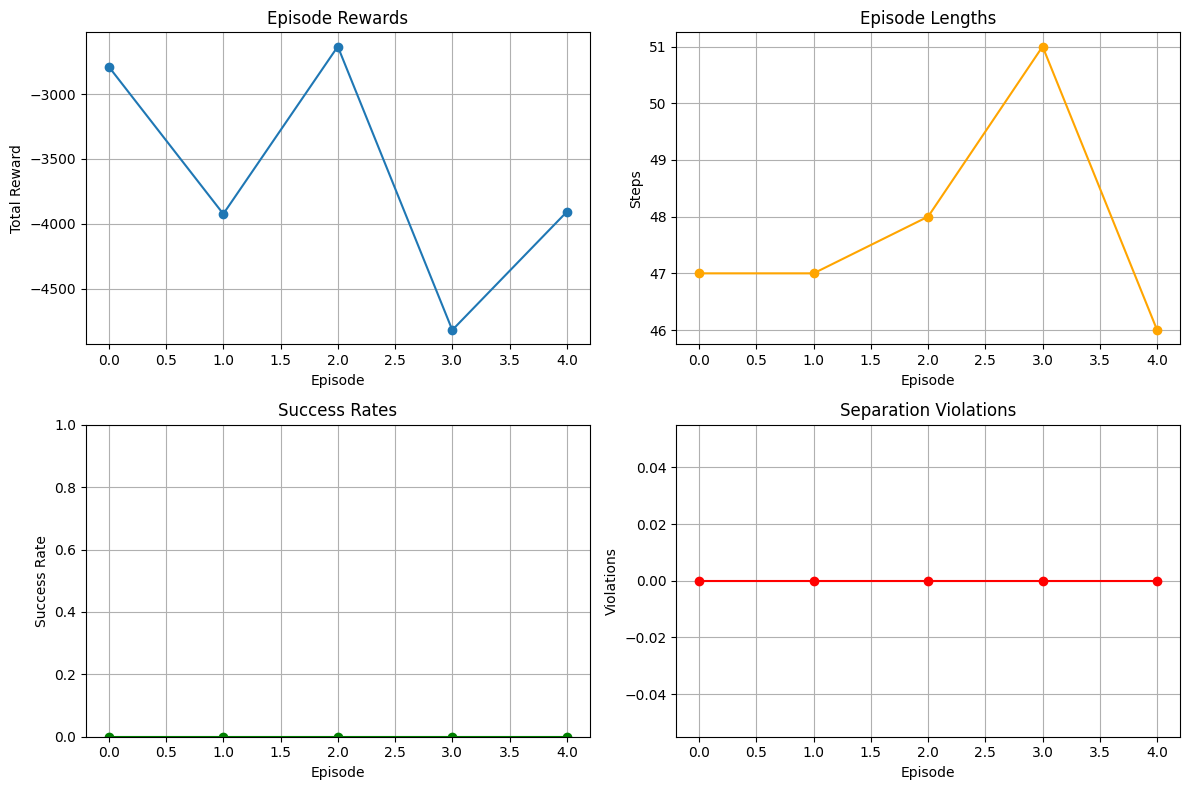

Visualizations complete!


In [ ]:
# [REMOVED] Old visualization code - see Section 3 for curriculum evaluation
print("✅ This section has been removed - evaluation is now integrated into Section 3")

## Section 4: Comparison vs Random Baseline

Let's compare the trained curriculum model against a random policy baseline across all stages.

In [ ]:
def evaluate_random_on_stage(stage, n_episodes=5):
    """Evaluate random policy on a specific curriculum stage."""
    print(f"\n{'='*60}")
    print(f"Random Baseline: {stage.name.upper()} ({stage.max_aircraft} aircraft)")
    print(f"{'='*60}")
    
    tracker = MetricsTracker()
    
    with masked_env(
        max_aircraft=stage.max_aircraft,
        episode_length=stage.episode_length,
    ) as random_env:
        
        # Update environment's score threshold for this stage
        random_env.unwrapped.config.reward_config.min_score_threshold = stage.min_score_threshold
        
        for episode in range(n_episodes):
            obs, info = random_env.reset()
            tracker.start_episode()
            
            done = False
            episode_reward = 0
            steps = 0
            
            while not done:
                action = random_env.action_space.sample()
                obs, reward, terminated, truncated, info = random_env.step(action)
                done = terminated or truncated
                
                episode_reward += reward
                steps += 1
                tracker.update(reward, info)
                
                if steps >= stage.episode_length:
                    break
            
            tracker.end_episode(info.get("episode_metrics", {}))
            violations = info.get("violations", 0)
            aircraft_count = info.get("aircraft_count", 0)
            print(f"  Episode {episode+1}: reward={episode_reward:7.1f}, steps={steps:3d}, "
                  f"violations={violations:2d}, aircraft={aircraft_count:2d}")
    
    # Calculate summary stats
    recent_episodes = tracker.get_recent_episodes(n_episodes)
    avg_reward = np.mean([ep.episode_reward for ep in recent_episodes])
    avg_length = np.mean([ep.episode_length for ep in recent_episodes])
    avg_violations = np.mean([ep.violations for ep in recent_episodes])
    avg_exits = np.mean([ep.successful_exits for ep in recent_episodes])
    
    print(f"\n  📊 {stage.name.upper()} Random Summary:")
    print(f"     Avg Reward: {avg_reward:7.1f}")
    print(f"     Avg Length: {avg_length:7.1f} steps")
    print(f"     Avg Violations: {avg_violations:5.1f}")
    print(f"     Avg Exits: {avg_exits:5.1f}")
    
    return {
        'stage': stage.name,
        'max_aircraft': stage.max_aircraft,
        'avg_reward': avg_reward,
        'avg_length': avg_length,
        'avg_violations': avg_violations,
        'avg_exits': avg_exits,
    }

# Evaluate random policy on all stages
print("🎲 RANDOM BASELINE EVALUATION")
print("="*60)
print("Testing random policy across curriculum stages...")

random_results = []
for stage in stages_to_train:
    result = evaluate_random_on_stage(stage, n_episodes=5)
    random_results.append(result)

# Comparison table: PPO vs Random
print(f"\n\n{'='*80}")
print("📊 PPO vs RANDOM COMPARISON")
print(f"{'='*80}")
print(f"{'Stage':<15} {'Aircraft':<10} {'PPO Reward':<12} {'Random Reward':<15} {'Improvement':<12}")
print(f"{'-'*80}")
for ppo_result, random_result in zip(evaluation_results, random_results):
    improvement = ((ppo_result['avg_reward'] - random_result['avg_reward']) / 
                   abs(random_result['avg_reward']) * 100)
    print(f"{ppo_result['stage']:<15} {ppo_result['max_aircraft']:<10} "
          f"{ppo_result['avg_reward']:<12.1f} {random_result['avg_reward']:<15.1f} "
          f"{improvement:+11.1f}%")
print(f"{'='*80}")

print("\n✅ Baseline comparison complete!")

Evaluating random policy...

  step=25 r=-30.01 aircraft=30 action=[38  3 14 12  0]
Episode 1: reward=-3914.29, steps=29
  step=25 r=9.99 aircraft=21 action=[16  1 14  6  7]
Episode 2: reward=-2366.46, steps=46
  step=25 r=-40.01 aircraft=27 action=[42  4  3  5  3]
Episode 3: reward=-3980.37, steps=37
  step=25 r=-232.01 aircraft=25 action=[40  0  1  1  5]
Episode 4: reward=-3006.41, steps=41
  step=25 r=-20.01 aircraft=23 action=[13  1  5  1  5]
Episode 5: reward=-2729.45, steps=45

Random policy evaluation complete!

METRICS SUMMARY (5 episodes)

Success Rate:        0.00% ± 0.00%
Violations:          0.00 ± 0.00
Collisions:          0.00 ± 0.00
Throughput:          0.00 ± 0.00 aircraft/hour
Avg Exit Time:       0.0 ± 0.0s
Command Efficiency:  0.00 ± 0.00 commands/aircraft
Episode Length:      40 ± 6 steps
Total Reward:        -3199.40 ± 643.87



---
**Note**: Old comparison section removed - comparison is now integrated into Section 4
---

In [ ]:
# [REMOVED] Old comparison code - see Section 4 for curriculum comparison
print("✅ This section has been removed - comparison is now integrated into Section 4")


COMPARISON: PPO vs Random Policy
Avg Reward                | PPO: -3614.88 | Random: -3199.40
Avg Success Rate          | PPO: 0.00% | Random: 0.00%
Avg Violations            | PPO: 0.00 | Random: 0.00
Avg Episode Length        | PPO: 47.80 | Random: 39.60

Reward Improvement: -13.0%

Note: This is a small demo with only 10k training steps.
For full training (500k+ steps), expect much better performance!


## Section 5: Save Model and Results

Let's save the trained model and results for later use.

In [ ]:
import json
from datetime import datetime

# Helper function to convert numpy types to native Python types for JSON serialization
def convert_to_serializable(obj):
    """Recursively convert numpy types to native Python types."""
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_to_serializable(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(item) for item in obj]
    else:
        return obj

# Create results directory
results_dir = Path("../results")
results_dir.mkdir(exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Final model is already saved during training - just report it
print(f"✅ Final model saved at: {stage_model_path}")

# Save comprehensive curriculum results
mode = "quick" if QUICK_MODE else "full"
results = {
    "timestamp": timestamp,
    "training_mode": mode,
    "stages_trained": [s.name for s in stages_to_train],
    "total_training_steps": sum(s.timesteps for s in stages_to_train),
    "ppo_evaluation": evaluation_results,
    "random_baseline": random_results,
    "curriculum_config": {
        "stages": [
            {
                "name": s.name,
                "max_aircraft": s.max_aircraft,
                "timesteps": s.timesteps,
                "episode_length": s.episode_length,
                "min_score_threshold": s.min_score_threshold,
            }
            for s in stages_to_train
        ]
    },
    "environment_config": {
        "airport": ENV_AIRPORT,
        "max_aircraft_capacity": ENV_MAX_AIRCRAFT,
        "timewarp": ENV_TIMEWARP,
        "headless": ENV_HEADLESS,
        "action_interval": ACTION_INTERVAL,
    },
}

# Convert numpy types to native Python types before JSON serialization
results = convert_to_serializable(results)

results_path = results_dir / f"curriculum_{mode}_{timestamp}.json"
with open(results_path, "w") as f:
    json.dump(results, f, indent=2)

print(f"📊 Results saved to: {results_path}")

# Print final summary
print(f"\n{'='*80}")
print("🎉 CURRICULUM TRAINING COMPLETE!")
print(f"{'='*80}")
print(f"Mode: {mode.upper()}")
print(f"Stages completed: {len(stages_to_train)}")
print(f"Total training steps: {sum(s.timesteps for s in stages_to_train):,}")
print(f"Final model: {stage_model_path}")
print(f"Results: {results_path}")
print(f"\n💡 Next steps:")
if QUICK_MODE:
    print(f"   - Set QUICK_MODE = False and rerun to train full curriculum")
    print(f"   - Review results to confirm fixes (episodes should be 200+ steps)")
else:
    print(f"   - Test on larger scenarios (15+ aircraft)")
    print(f"   - Try hierarchical RL (notebook 02)")
    print(f"   - Add behavioral cloning (notebook 03)")
print(f"{'='*80}")

# Log artifacts to wandb
# Log model artifact
artifact = wandb.Artifact(f"ppo-model-{timestamp}", type="model")
artifact.add_file(str(model_path))
wandb.log_artifact(artifact)
print(f"✅ Model logged to WandB: {artifact.name}")

# Log results JSON
artifact = wandb.Artifact(f"results-{timestamp}", type="results")
artifact.add_file(str(results_path))
wandb.log_artifact(artifact)
print(f"✅ Results logged to WandB: {artifact.name}")

# Log final evaluation metrics
wandb.log({
    "eval/avg_reward": ppo_summary.get("avg_total_reward", 0),
    "eval/avg_success_rate": ppo_summary.get("avg_success_rate", 0),
    "eval/avg_violations": ppo_summary.get("avg_separation_violations", 0),
    "eval/avg_episode_length": ppo_summary.get("avg_episode_length", 0),
})

# Finish wandb run
wandb.finish()
print("✅ WandB run finished")

print("\nDemo complete!")

Model saved to: ../results/ppo_demo_20251031_191727.zip
Results saved to: ../results/results_20251031_191727.json
✅ Model logged to WandB: ppo-model-20251031_191727
✅ Results logged to WandB: results-20251031_191727


avg_exits_10_episodes,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_length_10_episodes,▇▇▇█▅▇▆▅▅▁▇▆▆█▄█▆▇█▄▆▆▇
avg_reward_10_episodes,▆█▆██▅█▆▄▁▆▆▅▃▆▇█▅▅▃▆▆▇
avg_violations_10_episodes,▄▁▄▁▂▄▁▃▇█▄▄▄█▃▂▂▅▄▆▄▄▃
efficiency_score,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
episode_length,▅▆▆▅▂▅▅▅▃▇▆▄▃█▄▅▃▁▇▅▅▄▅▆▅▅▂▄▅▆▆▅▄▃▆▅▆▄▅▅
episode_reward,▁▄▄▅▆▇▆▅▅▄▄█▇▅▄▇▇▄▇▇▄▇▅▆▆▅▆▆▃█▄▃▆▃▅▃▃▄▅▂
eval/avg_episode_length,▁
eval/avg_reward,▁
eval/avg_success_rate,▁
+23,...


✅ WandB run finished

Demo complete!


---

## ✅ End of Baseline Demo

**Congratulations!** You've completed the curriculum learning baseline demo.

### What You've Learned:
1. ✅ Curriculum learning (3→5→8→12 aircraft progression)
2. ✅ Aggressive action masking (50-80x reduction)
3. ✅ Enhanced state features (20 aircraft features)
4. ✅ Dense reward shaping
5. ✅ Multi-stage evaluation
6. ✅ PPO vs Random baseline comparison

### Next Steps:
- **Hierarchical RL**: See `02_hierarchical_rl_demo.ipynb` for high-level/low-level policies
- **Behavioral Cloning**: See `03_behavioral_cloning_demo.ipynb` to bootstrap from expert data  
- **Multi-Agent**: See `04_multi_agent_demo.ipynb` for MAPPO coordination
- **World Models**: See `07_cosmos_world_model_demo.ipynb` for model-based RL